In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import time
import geopandas as gpd
import geodatasets
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import ticker
import seaborn as sns
import os

# Exploring categorization differences

### Are there significant differences in the assignment categories?

Notes from Week 4 Fellows check-in:
- are nulls in CPDB being replaced with values?
- same values for both methods vs. different values for both methods
- there are less nulls, there are more nulls, etc
- same or null in Checkbook NYC cat compared to CPDB is okay
- DIFFERENT in checkbook NYC cat compared to CPDB is not okay 
- use CPDB categories as the 'truth' and compare to that
- especially interested in cases where CPDB assigned the rows NULL, but Checkbook NYC gave them a category 
- do categories match between CPDB and checkbook NYC? 

In [2]:
checkbook = pd.read_csv('../data/checkbooknyc_geometries_with_cats.csv')
checkbook = checkbook[checkbook['_merge']=='both'] # filter to only include projects where geometries were joined 

In [3]:
# clean join
checkbook = checkbook.rename(columns={'typecatego':'cpdb_category', 'BudgetCode_Categories':'bc_category', 'Contracts_Categories': 'cp_category'})
checkbook['cpdb_category'].fillna('None', inplace=True)
checkbook['bc_category'].fillna('None', inplace=True)
checkbook['cp_category'].fillna('None', inplace=True)

## Add logic to implement high sensitivty method: assign category based on priorities (Fixed Asset --> ITT --> Lump Sum --> None)

In [22]:
# vals
cols = ['cpdb_category', 'bc_category', 'cp_category']
vals = checkbook['cpdb_category'].unique()
vals

array(['Fixed Asset', 'ITT, Vehicles, and Equipment', 'None', 'Lump Sum'],
      dtype=object)

In [19]:
drop_cols = ['Unnamed: 0', '_merge']
checkbook.drop(drop_cols, axis=1, inplace=True)

In [24]:
def assign_category(row):
    #cols = ['cpdb_category', 'bc_category', 'cp_category']
    cats = ['Fixed Asset', 'ITT, Vehicles, and Equipment', 'Lump Sum', 'None']
    
    if cats[0] in row.values:
        return cats[0]
    elif cats[1] in row.values:
        return cats[1]
    elif cats[2] in row.values:
        return cats[2]
    else:
        return cats[3]

In [25]:
checkbook['final_category'] = checkbook.apply(lambda row: assign_category(row), axis=1)

## CPDB Categories vs. Budget Code Categories (Method 1)

In [6]:
crosstab_bc_counts = pd.crosstab(checkbook['cpdb_category'], checkbook['bc_category'], rownames=['CPDB Category'], colnames=['Budget Code Category'], margins=True, margins_name='Total')
crosstab_bc_props_cols = pd.crosstab(checkbook['cpdb_category'], checkbook['bc_category'], rownames=['CPDB Category'], colnames=['Budget Code Category'], normalize='columns')
crosstab_bc_props_rows = pd.crosstab(checkbook['cpdb_category'], checkbook['bc_category'], rownames=['CPDB Category'], colnames=['Budget Code Category'], normalize='index')
crosstab_bc_props = pd.crosstab(checkbook['cpdb_category'], checkbook['bc_category'], rownames=['CPDB Category'], colnames=['Budget Code Category'], normalize=True)
crosstab_bc_counts_nomargins = pd.crosstab(checkbook['cpdb_category'], checkbook['bc_category'], rownames=['CPDB Category'], colnames=['Budget Code Category'])


In [7]:
crosstab_bc_counts_nomargins.to_clipboard(excel=True)

In [8]:
crosstab_bc_props_rows.to_clipboard(excel=True)

*Note: These cross tabulation numbers are calculated by looking at ONLY Checkbook NYC projects that successfully joined on CPDB geometries. 29,813 projects out of 80,932 successfully joined to CPDB geometries.*

Interpretation of counts:
- 15,127 Checkbook NYC projects with geometries are categorized as 'Fixed Asset' in both the joined CPDB geometry and when categorized using `Budget Code`. This is out of a total of 20,155 projects assigned 'Fixed Asset' by the joined CPDB geometry, and 20,868 projects assigned 'Fixed Asset' when categorized using `Budget Code`.
- `Budget Code` assigned 713 more projects to the `Fixed Asset` category than CPDB alone. 
- 5,680 Checkbook NYC projects are not assigned a category by the joined CPDB geometry, of which 3,507 are also not categorized using `Budget Code`. This means that 2,173  projects which are not categorized in CPDB are assigned a category using the `Budget Code` column in the joined Checkbook NYC project.

Interpretation of row-wise proportions:
- It makes sense to analyze the cross-tabulation proportions row-wise, i.e. in relation to the CPDB category assignment, because we are treating the CPDB category assignments as the truth.  
- 75.05% of projects categorized as 'Fixed Asset' by joining on CPDB have the same assignment when categorized on `Budget Code`. 14.19% of projects categorized as 'Fixed Asset' by joining on CPDB are not assigned a category when categorized on `Budget Code`. 
- 61.74% of projects not assigned a category by joining on CPDB are assigned 'Fixed Asset' when categorized on `Budget Code`. 21.79% of projects with geometries are not categorized by either approach. 

In [9]:
category_colors = {
    'Fixed Asset': 'indianred', 
    'Lump Sum': 'gold', 
    'ITT, Vehicles, and Equipment': 'cornflowerblue', 
    'None': 'lightsteelblue'
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


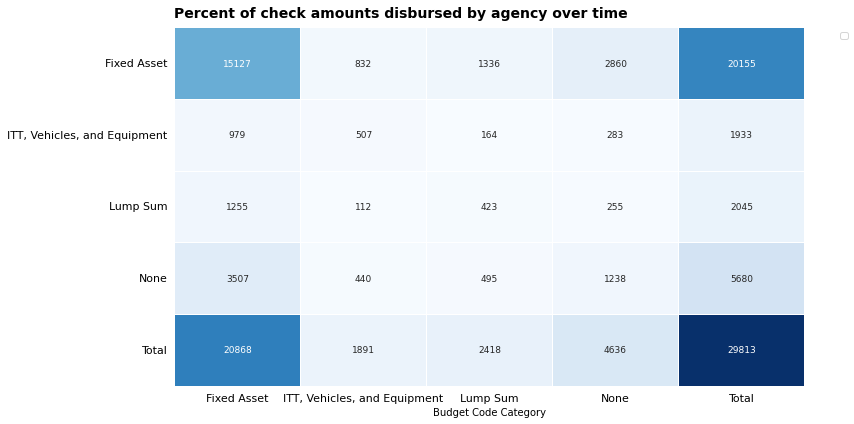

In [10]:
# --- heat map

fig, axs = plt.subplots(figsize=(12,6), nrows = 1)
ax = axs

sns.heatmap(
    crosstab_bc_counts,
    cmap = 'Blues',
    annot = True,
    fmt = '.0f',
    annot_kws = {'fontsize':9},
    cbar = False,
    linewidths = 1,
    linecolor = 'w',
    ax = ax
)
ax.legend( loc = 'upper left', bbox_to_anchor = (1.05,1), ncol = 1, fontsize = 9 )
#ax.set_xticklabels( [ x.strftime('%Y') for x in pivot_data ] , rotation = 0, ha = 'center' )
ax.tick_params( axis = 'both', which = 'both', left = False, bottom = False, labelsize = 11 )
ax.set_ylabel('')
ax.set_title( "Percent of check amounts disbursed by agency over time", fontsize = 14, fontweight = 'bold', loc = 'left', color = 'black' , pad = 10 )

plt.tight_layout( w_pad = 1 )
plt.show()

## CPDB Categories vs. Contract Purpose Categories (Method 2) 

In [11]:
crosstab_cp_counts = pd.crosstab(checkbook['cpdb_category'], checkbook['cp_category'], rownames=['CPDB Category'], colnames=['Contract Purpose Category'], margins=True, margins_name='Total')
crosstab_cp_props_cols = pd.crosstab(checkbook['cpdb_category'], checkbook['cp_category'], rownames=['CPDB Category'], colnames=['Contract Purpose Category'], normalize='columns')
crosstab_cp_props_rows = pd.crosstab(checkbook['cpdb_category'], checkbook['cp_category'], rownames=['CPDB Category'], colnames=['Contract Purpose Category'], normalize='index')
crosstab_cp_props = pd.crosstab(checkbook['cpdb_category'], checkbook['cp_category'], rownames=['CPDB Category'], colnames=['Contract Purpose Category'], normalize=True)

In [12]:
crosstab_cp_counts

Contract Purpose Category,Fixed Asset,"ITT, Vehicles, and Equipment",Lump Sum,None,Total
CPDB Category,,,,,
Fixed Asset,15221,2491,1995,448,20155
"ITT, Vehicles, and Equipment",745,993,176,19,1933
Lump Sum,1251,234,512,48,2045
None,3645,924,858,253,5680
Total,20862,4642,3541,768,29813


In [13]:
crosstab_cp_props_rows

Contract Purpose Category,Fixed Asset,"ITT, Vehicles, and Equipment",Lump Sum,None
CPDB Category,,,,
Fixed Asset,0.755197,0.123592,0.098983,0.022228
"ITT, Vehicles, and Equipment",0.385411,0.513709,0.091050,0.009829
Lump Sum,0.611736,0.114425,0.250367,0.023472
None,0.641725,0.162676,0.151056,0.044542


*Note: These cross tabulation numbers are calculated by looking at ONLY Checkbook NYC projects that successfully joined on CPDB geometries. 29,813 projects out of 80,932 successfully joined to CPDB geometries.*

Interpretation of counts:
- 15,221 Checkbook NYC projects with geometries are categorized as 'Fixed Asset' in both the joined CPDB geometry and when categorized using `Contract Purpose`. This is out of a total of 20,155 projects assigned 'Fixed Asset' by the joined CPDB geometry, and 20,862 projects assigned 'Fixed Asset' when categorized using `Contract Purpose`.
- `Contract Purpose` assigned 707 more projects to the `Fixed Asset` category than CPDB alone. 
- 5,680 Checkbook NYC projects are not assigned a category by the joined CPDB geometry, of which only 253 are also not categorized using `Contract Purpose`. 
    - This means that 5,427 projects which are not categorized in CPDB are assigned a category using `Contract Purpose`.
- Only 768 projects with geometries are not categorized when the assignment process uses `Contract Purpose`. 

Interpretation of row-wise proportions:
- 75.52% of projects categorized as 'Fixed Asset' by joining on CPDB have the same assignment when categorized on `Contract Purpose`. 9.9% of projects categorized as 'Fixed Asset' by joining on CPDB are not assigned a category when categorized on `Contract Purpose`. 
- 64.17% of projects not assigned a category by joining on CPDB are assigned 'Fixed Asset' when categorized on `Budget Code`. Only 4.45% of projects with geometries are not categorized by either approach. 

## CPDB Categories vs. both Method 1 and Method 2

In [14]:
crosstab_counts = pd.crosstab(checkbook['cpdb_category'], [checkbook['bc_category'], checkbook['cp_category']], rownames=['CPDB Category'], colnames=['Budget Code Category', 'Contract Purpose Category'])

In [15]:
crosstab_counts

Budget Code Category         Fixed Asset                               \
Contract Purpose Category    Fixed Asset ITT, Vehicles, and Equipment   
CPDB Category                                                           
Fixed Asset                        13830                         1297   
ITT, Vehicles, and Equipment         658                          321   
Lump Sum                            1221                           34   
None                                3194                          313   

Budget Code Category         ITT, Vehicles, and Equipment  \
Contract Purpose Category    ITT, Vehicles, and Equipment   
CPDB Category                                               
Fixed Asset                                           832   
ITT, Vehicles, and Equipment                          507   
Lump Sum                                              112   
None                                                  440   

Budget Code Category                             Lump Sum           \
Contract Purpose Category    ITT, Vehicles, and Equipment Lump Sum   
CPDB Category                                                        
Fixed Asset                                           119     1217   
ITT, Vehicles, and Equipment                           61      103   
Lump Sum                                               60      363   
None                                                   44      451   

Budget Code Category                None                               \
Contract Purpose Category    Fixed Asset ITT, Vehicles, and Equipment   
CPDB Category                                                           
Fixed Asset                         1391                          243   
ITT, Vehicles, and Equipment          87                          104   
Lump Sum                              30                           28   
None                                 451                          127   

Budget Code Category                        
Contract Purpose Category    Lump Sum None  
CPDB Category                               
Fixed Asset                       778  448  
ITT, Vehicles, and Equipment       73   19  
Lump Sum                          149   48  
None                              407  253